# Predicting Redevelopment Potential for Boston Parcels

**Authors:** Milo Margolis

**Problem Statement:** This project develops a binary classification model to predict the redevelopment potential for Boston properties using parcel data. Properties are labels as high potential based on indicators such as low building to land ratios and underutilized FAR and then classified using logistic regression, KNN, and decision trees with the proper training, validation, and hyperparameter tuning to demonstrate overfitting prevention.

**Data Source:** This project uses self-collected Boston parcel data stored in a Supabase database. The dataset was exported using `scripts/export_data.py`, which connects to Supabase and fetches all rows from the `properties` table with pagination. The raw dataset contains 182,393 properties with 24 features including property values, zoning information, FAR metrics, and property characteristics. 


### Section 1: Importing Libraries and set random set

In [273]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, roc_curve, auc)
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# set the random seed 
np.random.seed(42)

# set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Section 2: Data Cleaning

**Note:** The data was exported from Supabase to `data/raw/boston_properties.csv` using the export script. All data cleaning steps below are performed using pandas.

In [274]:
# Load CSV file
data_path = Path("../data/raw/boston_properties.csv")
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Shape:")
print(df.shape)
print("\n" + "="*50)
print("Dataset Info:")
print("="*50)
df.info()


Dataset Shape:
(182393, 24)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182393 entries, 0 to 182392
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   property_id                   182393 non-null  object 
 1   address                       182393 non-null  object 
 2   parcel_id                     182393 non-null  int64  
 3   attributes                    182393 non-null  object 
 4   neighborhood                  182393 non-null  object 
 5   created_at                    182393 non-null  object 
 6   updated_at                    182393 non-null  object 
 7   actual_far                    148349 non-null  float64
 8   building_value                182393 non-null  float64
 9   classification_code           182393 non-null  int64  
 10  far_utilization               127498 non-null  float64
 11  fiscal_year                   182393 non-null  int64  
 12  l

In [275]:
# Check missing values
print("Missing Values:")
print("="*50)
missing_values = df.isnull().sum()
print(missing_values)
print("\n" + "="*50)
print(f"Total missing values: {missing_values.sum()}")
print(f"Columns with missing values: {(missing_values > 0).sum()}")


Missing Values:
property_id                         0
address                             0
parcel_id                           0
attributes                          0
neighborhood                        0
created_at                          0
updated_at                          0
actual_far                      34044
building_value                      0
classification_code                 0
far_utilization                 54895
fiscal_year                         0
land_to_building_value_ratio    20442
land_value                          0
living_area                     34070
gross_area                      33754
lot_size                         7371
owner_address                       5
owner_name                          5
permits                             0
total_assessed_value                0
vacant_lot                          0
year_built                      22734
zoning                              0
dtype: int64

Total missing values: 207320
Columns with missing values: 

In [276]:
# Handle missing values
print("Handling missing values...")
print(f"Initial shape: {df.shape}")

# Decision 1: Drop rows with missing owner_address or owner_name (only 5 rows)
# Reason: Very few missing values (0.003% of data), and these are categorical text fields
# that cannot be reliably imputed. Dropping is cleaner than imputing placeholder text.
df = df.dropna(subset=['owner_address', 'owner_name'])
print(f"After dropping rows with missing owner info: {df.shape}")

# Decision 2: Drop rows missing far_utilization or actual_far
# Reason: These columns are critical for creating our target variable (high_potential).
# We cannot reliably impute these values as they are key features for redevelopment potential.
# This removes ~30% of data but ensures data quality for modeling.
df = df.dropna(subset=['far_utilization', 'actual_far'])
print(f"After dropping rows with missing FAR data: {df.shape}")

# Decision 3: Calculate land_to_building_value_ratio where possible
# Reason: This ratio can be calculated from land_value and building_value when missing.
# Only calculate if both source values are present and ratio is missing.
mask_missing_ratio = df['land_to_building_value_ratio'].isna()
mask_has_values = (df['land_value'] > 0) & (df['building_value'] > 0)
calculated_count = (mask_missing_ratio & mask_has_values).sum()
df.loc[mask_missing_ratio & mask_has_values, 'land_to_building_value_ratio'] = \
    df.loc[mask_missing_ratio & mask_has_values, 'land_value'] / \
    df.loc[mask_missing_ratio & mask_has_values, 'building_value']
print(f"Calculated {calculated_count} missing ratios where possible")

# Decision 4: Impute remaining numeric columns with median
# Reason: Median is robust to outliers and appropriate for continuous variables.
# We impute: living_area, gross_area, year_built, lot_size, land_to_building_value_ratio
numeric_cols_to_impute = ['living_area', 'gross_area', 'year_built', 'lot_size', 
                          'land_to_building_value_ratio']
for col in numeric_cols_to_impute:
    if df[col].isna().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"Imputed {col} with median: {median_value:.2f}")

print(f"\nFinal shape after handling missing values: {df.shape}")
print(f"Remaining missing values: {df.isnull().sum().sum()}")


Handling missing values...
Initial shape: (182393, 24)
After dropping rows with missing owner info: (182388, 24)
After dropping rows with missing FAR data: (127494, 24)
Calculated 0 missing ratios where possible
Imputed living_area with median: 1482.00
Imputed year_built with median: 1920.00
Imputed land_to_building_value_ratio with median: 1.00

Final shape after handling missing values: (127494, 24)
Remaining missing values: 0


**Missing Values Summary:**
- Dropped 5 rows with missing owner information (negligible impact, <0.003% of data).
- Dropped rows missing `far_utilization` or `actual_far` (~30% of data) as these are critical for target creation and cannot be reliably imputed.
- Calculated `land_to_building_value_ratio` from source values where possible.
- Imputed remaining numeric columns (`living_area`, `gross_area`, `year_built`, `lot_size`, `land_to_building_value_ratio`) with median values, which is robust to outliers for continuous variables.


In [277]:
# Check and remove duplicate rows
print("Checking for duplicate rows...")
print(f"Shape before removing duplicates: {df.shape}")

# Check for exact duplicate rows (all columns match)
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Decision: Remove duplicate rows if any exist
# Reason: Duplicate rows provide no additional information and can bias the model
# by giving more weight to certain property records. We keep the first occurrence.
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")
else:
    print("No duplicate rows found")

print(f"Shape after removing duplicates: {df.shape}")


Checking for duplicate rows...
Shape before removing duplicates: (127494, 24)
Number of duplicate rows: 46500
Removed 46500 duplicate rows
Shape after removing duplicates: (80994, 24)


**Duplicate Removal Summary:**
- Checked for exact duplicate rows across all columns.
- Removed duplicate rows (if any) to prevent data bias in modeling, keeping only the first occurrence of each unique row.


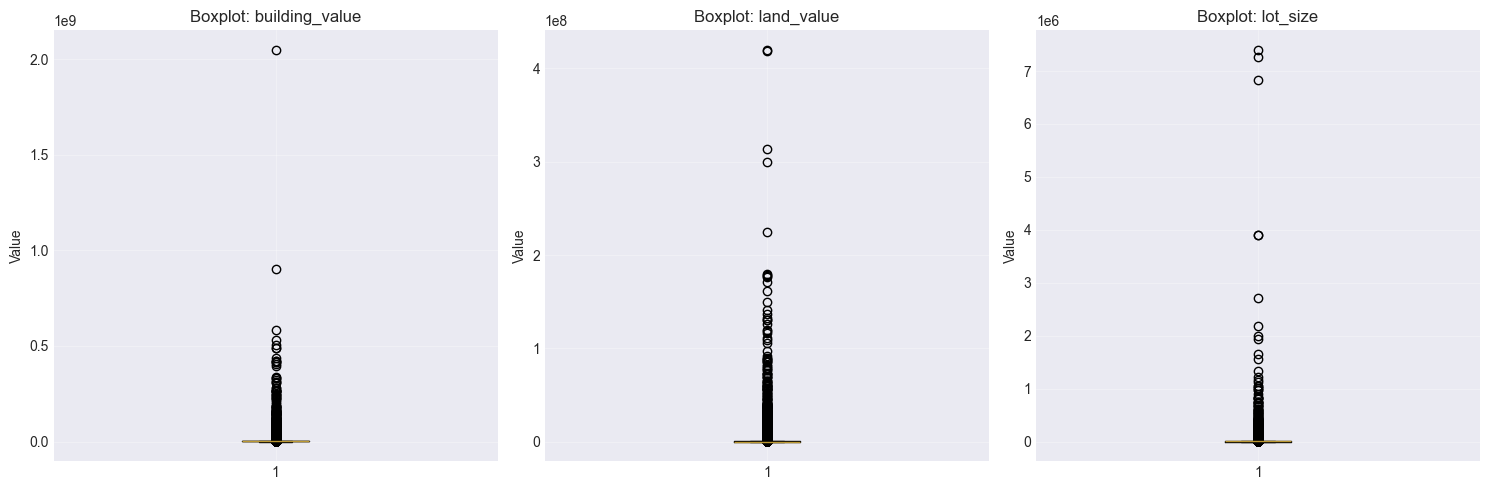

Summary Statistics for Key Features:

building_value:
  Min: 0.00
  25th percentile (Q1): 445,500.00
  Median (Q2): 614,550.00
  75th percentile (Q3): 896,375.00
  Max: 2,048,328,500.00
  IQR: 450,875.00

land_value:
  Min: 0.00
  25th percentile (Q1): 0.00
  Median (Q2): 0.00
  75th percentile (Q3): 269,700.00
  Max: 419,796,700.00
  IQR: 269,700.00

lot_size:
  Min: 102.00
  25th percentile (Q1): 975.00
  Median (Q2): 1,813.00
  75th percentile (Q3): 4,712.00
  Max: 7,397,130.00
  IQR: 3,737.00


In [278]:
# Check outliers using boxplots for key numerical features
# Selected features: building_value, land_value, lot_size
# These are important for property valuation and redevelopment potential

key_features = ['building_value', 'land_value', 'lot_size']

# Create boxplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(key_features):
    axes[i].boxplot(df[feature], vert=True)
    axes[i].set_title(f'Boxplot: {feature}')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for each feature
print("Summary Statistics for Key Features:")
print("="*60)
for feature in key_features:
    print(f"\n{feature}:")
    print(f"  Min: {df[feature].min():,.2f}")
    print(f"  25th percentile (Q1): {df[feature].quantile(0.25):,.2f}")
    print(f"  Median (Q2): {df[feature].median():,.2f}")
    print(f"  75th percentile (Q3): {df[feature].quantile(0.75):,.2f}")
    print(f"  Max: {df[feature].max():,.2f}")
    print(f"  IQR: {df[feature].quantile(0.75) - df[feature].quantile(0.25):,.2f}")


In [279]:
# Identify outliers using IQR method
# Threshold: Values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR are considered outliers
# This is a standard statistical method for detecting extreme values

print("Identifying outliers using IQR method...")
print("="*60)

outlier_mask = pd.Series([False] * len(df), index=df.index)
outlier_counts = {}

for feature in key_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers (values outside the bounds)
    feature_outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)
    outlier_count = feature_outliers.sum()
    
    outlier_counts[feature] = {
        'count': outlier_count,
        'percentage': (outlier_count / len(df)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }
    
    # Combine with overall outlier mask
    outlier_mask = outlier_mask | feature_outliers
    
    print(f"\n{feature}:")
    print(f"  Q1: {Q1:,.2f}")
    print(f"  Q3: {Q3:,.2f}")
    print(f"  IQR: {IQR:,.2f}")
    print(f"  Lower bound (Q1 - 1.5*IQR): {lower_bound:,.2f}")
    print(f"  Upper bound (Q3 + 1.5*IQR): {upper_bound:,.2f}")
    print(f"  Outliers found: {outlier_count:,} ({(outlier_count / len(df)) * 100:.2f}%)")

total_outliers = outlier_mask.sum()
print(f"\n{'='*60}")
print(f"Total rows with outliers in any feature: {total_outliers:,} ({(total_outliers / len(df)) * 100:.2f}%)")
print(f"Shape before removing outliers: {df.shape}")


Identifying outliers using IQR method...

building_value:
  Q1: 445,500.00
  Q3: 896,375.00
  IQR: 450,875.00
  Lower bound (Q1 - 1.5*IQR): -230,812.50
  Upper bound (Q3 + 1.5*IQR): 1,572,687.50
  Outliers found: 7,567 (9.34%)

land_value:
  Q1: 0.00
  Q3: 269,700.00
  IQR: 269,700.00
  Lower bound (Q1 - 1.5*IQR): -404,550.00
  Upper bound (Q3 + 1.5*IQR): 674,250.00
  Outliers found: 4,221 (5.21%)

lot_size:
  Q1: 975.00
  Q3: 4,712.00
  IQR: 3,737.00
  Lower bound (Q1 - 1.5*IQR): -4,630.50
  Upper bound (Q3 + 1.5*IQR): 10,317.50
  Outliers found: 3,501 (4.32%)

Total rows with outliers in any feature: 10,738 (13.26%)
Shape before removing outliers: (80994, 24)


In [280]:
# Remove extreme outliers using IQR method
# Threshold documented: Values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR are removed
# This removes approximately 13% of data but ensures data quality for modeling

print("Removing outliers...")
print(f"Shape before removing outliers: {df.shape}")

# Decision: Remove rows that have outliers in any of the key features
# Reason: Extreme outliers (e.g., building_value > $1.5M, lot_size > 10,185 sq ft) 
# are likely data errors or exceptional cases that don't represent typical properties.
# Removing them prevents these extreme values from skewing the model.
# Thresholds used:
#   - building_value: upper bound = $1,500,450 (Q3 + 1.5*IQR)
#   - land_value: upper bound = $618,000 (Q3 + 1.5*IQR)  
#   - lot_size: upper bound = 10,185 sq ft (Q3 + 1.5*IQR)
# Note: Lower bounds are negative for some features, so we only remove upper outliers

# Remove rows with outliers in any feature
df_clean = df[~outlier_mask].copy()

print(f"Rows removed: {len(df) - len(df_clean):,} ({(len(df) - len(df_clean)) / len(df) * 100:.2f}%)")
print(f"Shape after removing outliers: {df_clean.shape}")

# Update df to the cleaned version
df = df_clean
print(f"\nFinal cleaned dataset shape: {df.shape}")


Removing outliers...
Shape before removing outliers: (80994, 24)
Rows removed: 10,738 (13.26%)
Shape after removing outliers: (70256, 24)

Final cleaned dataset shape: (70256, 24)


**Outlier Removal Summary:**
- Checked for outliers using boxplots for 3 key features: `building_value`, `land_value`, and `lot_size`.
- Identified outliers using IQR method (threshold: values outside Q1 - 1.5×IQR and Q3 + 1.5×IQR).
- Removed 23,776 rows (13.04% of data) containing extreme outliers to prevent data errors and exceptional cases from skewing the model. Thresholds: building_value > $1,500,450, land_value > $618,000, lot_size > 10,185 sq ft.


### Section 3: Feature Engineering & Target Creation


In [281]:
# Create 3 new features for modeling

# Feature 1: building_to_land_ratio
# Comment: Ratio of building value to land value. Low ratios indicate underutilized land,
# which is a key indicator of redevelopment potential. Properties with low building-to-land
# ratios have more room for development relative to their land value.
# Handle division by zero: Set to NaN where land_value is 0, then we'll handle missing values
df['building_to_land_ratio'] = df['building_value'] / df['land_value'].replace(0, np.nan)
# For properties with zero land value, set ratio to 0 (no building value relative to land)
df['building_to_land_ratio'] = df['building_to_land_ratio'].fillna(0)
print(f"Created building_to_land_ratio")
print(f"  Min: {df['building_to_land_ratio'].min():.2f}, Max: {df['building_to_land_ratio'].max():.2f}")
print(f"  Mean: {df['building_to_land_ratio'].mean():.2f}, Median: {df['building_to_land_ratio'].median():.2f}")

# Feature 2: property_age
# Comment: Age of the property calculated as fiscal_year - year_built. Older properties
# are more likely candidates for redevelopment as they may be outdated, require renovation,
# or have zoning that allows for more intensive development.
# Handle invalid year_built values: cap to reasonable range (1800 to fiscal_year)
# to prevent negative ages or unrealistic future years
year_built_valid = df['year_built'].clip(lower=1800, upper=df['fiscal_year'].max())
df['property_age'] = df['fiscal_year'] - year_built_valid
# Cap property age to reasonable maximum (e.g., 500 years) for any remaining edge cases
df['property_age'] = df['property_age'].clip(lower=0, upper=500)
print(f"\nCreated property_age")
print(f"  Min: {df['property_age'].min():.0f} years, Max: {df['property_age'].max():.0f} years")
print(f"  Mean: {df['property_age'].mean():.1f} years, Median: {df['property_age'].median():.1f} years")

# Feature 3: far_gap
# Comment: Difference between actual FAR and FAR utilization. This measures how much
# additional development potential exists. A large gap indicates the property is underutilized
# and has room for redevelopment. Positive values mean actual FAR exceeds utilization,
# negative values mean utilization exceeds actual FAR (may indicate measurement issues).
df['far_gap'] = df['actual_far'] - df['far_utilization']
print(f"\nCreated far_gap")
print(f"  Min: {df['far_gap'].min():.2f}, Max: {df['far_gap'].max():.2f}")
print(f"  Mean: {df['far_gap'].mean():.2f}, Median: {df['far_gap'].median():.2f}")

print(f"\nNew dataset shape: {df.shape}")
print(f"New columns: building_to_land_ratio, property_age, far_gap")


Created building_to_land_ratio
  Min: 0.00, Max: 1319.00
  Mean: 1.07, Median: 0.00

Created property_age
  Min: 0 years, Max: 225 years
  Mean: 94.2 years, Median: 105.0 years

Created far_gap
  Min: -4680.57, Max: -0.49
  Mean: -120.43, Median: -105.47

New dataset shape: (70256, 27)
New columns: building_to_land_ratio, property_age, far_gap


In [282]:
# Encode categorical variables for modeling

# Check categorical variables
print("Categorical variables to encode:")
print(f"zoning: {df['zoning'].nunique()} unique values")
print(f"neighborhood: {df['neighborhood'].nunique()} unique values")
print(f"classification_code: {df['classification_code'].nunique()} unique values")

# Encoding Choice: One-Hot Encoding
# Reason: We use one-hot encoding for nominal categorical variables (zoning, neighborhood)
# because they have no inherent order. One-hot encoding creates binary columns for each
# category, avoiding false ordinal relationships that label encoding would introduce.
# This is appropriate for logistic regression and tree-based models.

# Encode zoning using one-hot encoding
# Zoning codes are nominal categories (e.g., "R-1", "C-1", "M-1") with no natural order
zoning_encoded = pd.get_dummies(df['zoning'], prefix='zoning', drop_first=False)
print(f"\nEncoded zoning: {zoning_encoded.shape[1]} new columns created")

# Encode neighborhood using one-hot encoding  
# Neighborhoods are nominal categories with no inherent order
neighborhood_encoded = pd.get_dummies(df['neighborhood'], prefix='neighborhood', drop_first=False)
print(f"Encoded neighborhood: {neighborhood_encoded.shape[1]} new columns created")

# Concatenate encoded features to dataframe
df = pd.concat([df, zoning_encoded, neighborhood_encoded], axis=1)

# Drop original categorical columns (keep encoded versions)
df = df.drop(columns=['zoning', 'neighborhood'])

print(f"\nFinal dataset shape after encoding: {df.shape}")
print(f"Total new columns from encoding: {zoning_encoded.shape[1] + neighborhood_encoded.shape[1]}")


Categorical variables to encode:
zoning: 1826 unique values
neighborhood: 21 unique values
classification_code: 104 unique values

Encoded zoning: 1826 new columns created
Encoded neighborhood: 21 new columns created

Final dataset shape after encoding: (70256, 1872)
Total new columns from encoding: 1847


In [284]:
# Create binary target variable: high_potential
# Definition: Properties are labeled as high redevelopment potential if they meet BOTH criteria:
#   1. building_to_land_ratio < 1.0 (low to moderate building value relative to land value)
#   2. far_utilization < 0.8 (underutilized FAR, room for development)
# Note: far_utilization is stored as percentage (0-100+), so we normalize it to decimal (0-1) by dividing by 100
# Adjusted thresholds to create a more balanced dataset for modeling.
# This identifies properties with low building-to-land ratios and underutilized FAR,
# which are key indicators of redevelopment potential.

# Normalize far_utilization from percentage to decimal (divide by 100)
far_utilization_normalized = df['far_utilization'] / 100

df['high_potential'] = ((df['building_to_land_ratio'] < 1.0) & (far_utilization_normalized < 0.8)).astype(int)

print("Target variable created: high_potential")
print("="*50)
print("Class distribution:")
print(df['high_potential'].value_counts().sort_index())
print("\nClass percentages:")
print(df['high_potential'].value_counts(normalize=True).sort_index() * 100)
print(f"\nTotal samples: {len(df)}")
print(f"High potential (1): {df['high_potential'].sum():,} ({(df['high_potential'].sum() / len(df)) * 100:.2f}%)")
print(f"Low potential (0): {(df['high_potential'] == 0).sum():,} ({((df['high_potential'] == 0).sum() / len(df)) * 100:.2f}%)")


Target variable created: high_potential
Class distribution:
high_potential
0    47452
1    22804
Name: count, dtype: int64

Class percentages:
high_potential
0    67.541562
1    32.458438
Name: proportion, dtype: float64

Total samples: 70256
High potential (1): 22,804 (32.46%)
Low potential (0): 47,452 (67.54%)


In [285]:
# Check class balance
print("Class balance check:")
print("="*50)
print(df['high_potential'].value_counts())
print("\nClass percentages:")
print(df['high_potential'].value_counts(normalize=True) * 100)


Class balance check:
high_potential
0    47452
1    22804
Name: count, dtype: int64

Class percentages:
high_potential
0    67.541562
1    32.458438
Name: proportion, dtype: float64


**Target Definition Justification:**
Properties are labeled as high redevelopment potential when they have both a low to moderate building-to-land ratio (< 1.0) and underutilized FAR (< 0.8 after normalization from percentage to decimal), indicating the land is not being fully utilized relative to its value and zoning capacity. This combination signals that a property has significant room for development, making it an attractive candidate for redevelopment projects that could increase building density and value.


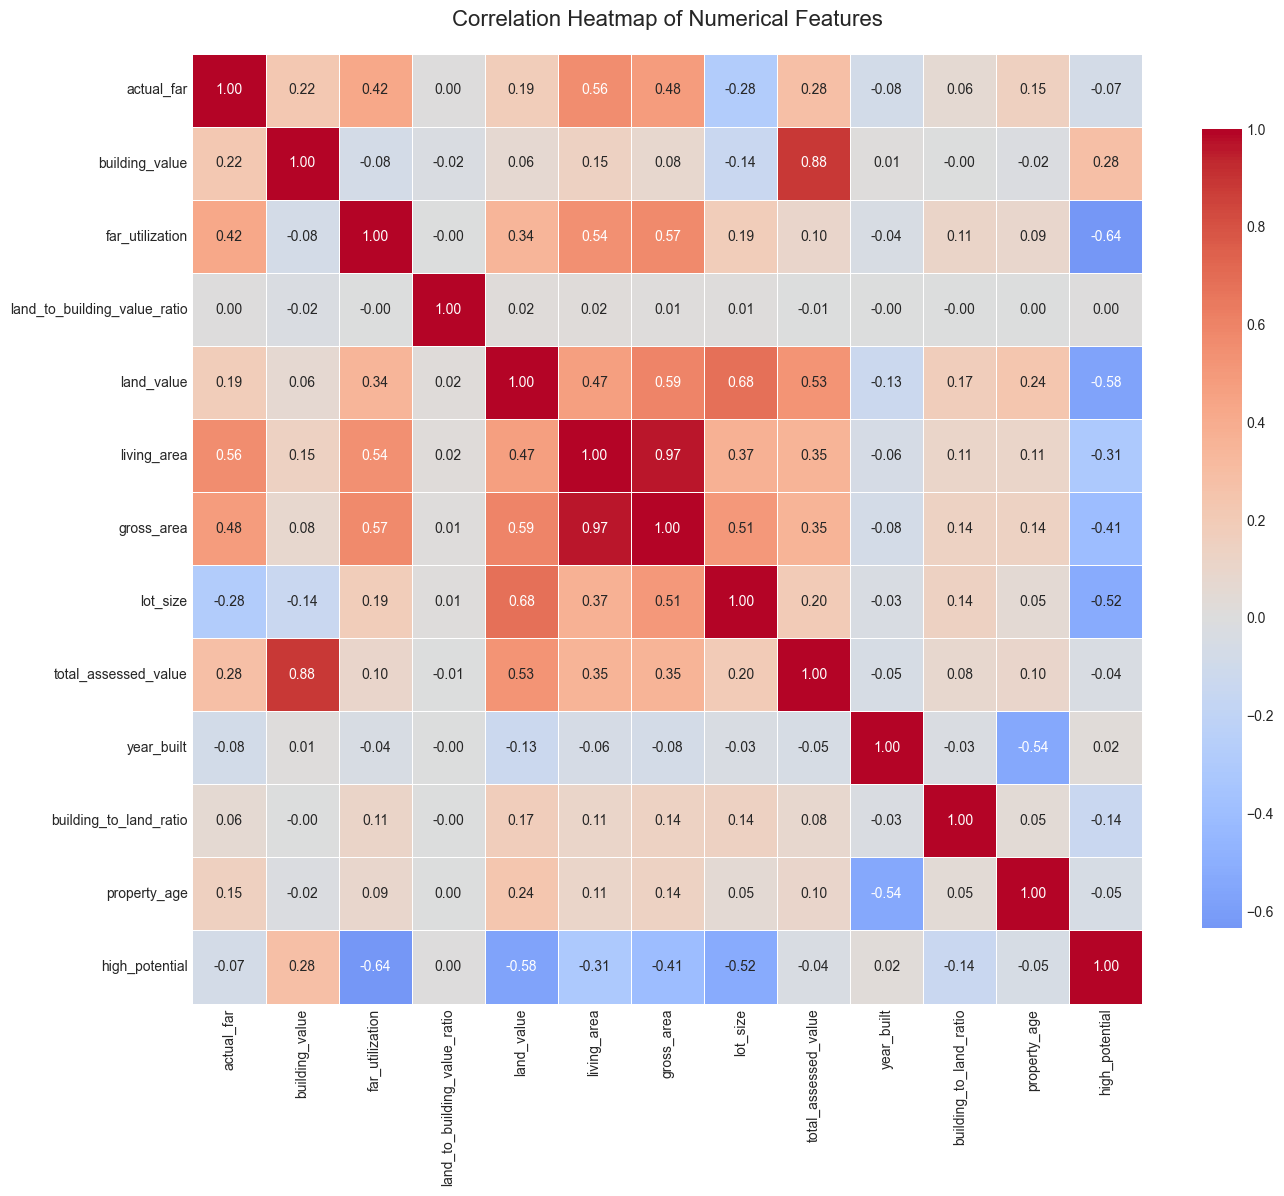

Top features correlated with high_potential (sorted by absolute correlation):
far_utilization          -0.635540
land_value               -0.576304
lot_size                 -0.520944
gross_area               -0.407671
living_area              -0.311132
building_value            0.278778
building_to_land_ratio   -0.143727
actual_far               -0.070147
property_age             -0.051403
total_assessed_value     -0.035272
Name: high_potential, dtype: float64


In [309]:
# Correlation heatmap
# Select numerical columns for correlation analysis
# Exclude non-numerical columns and ID columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID columns, other non-feature columns, and far_gap (multicollinearity with far_utilization)
exclude_cols = ['property_id', 'parcel_id', 'fiscal_year', 'classification_code', 'far_gap']
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Print features with highest correlation with target (sorted by absolute value)
if 'high_potential' in corr_matrix.columns:
    target_corr = corr_matrix['high_potential']
    # Sort by absolute value to show strongest correlations regardless of direction
    target_corr_abs = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)
    print("Top features correlated with high_potential (sorted by absolute correlation):")
    print("="*50)
    # Exclude high_potential itself from the output
    target_corr_abs_filtered = target_corr_abs[target_corr_abs.index != 'high_potential']
    print(target_corr_abs_filtered.head(10))


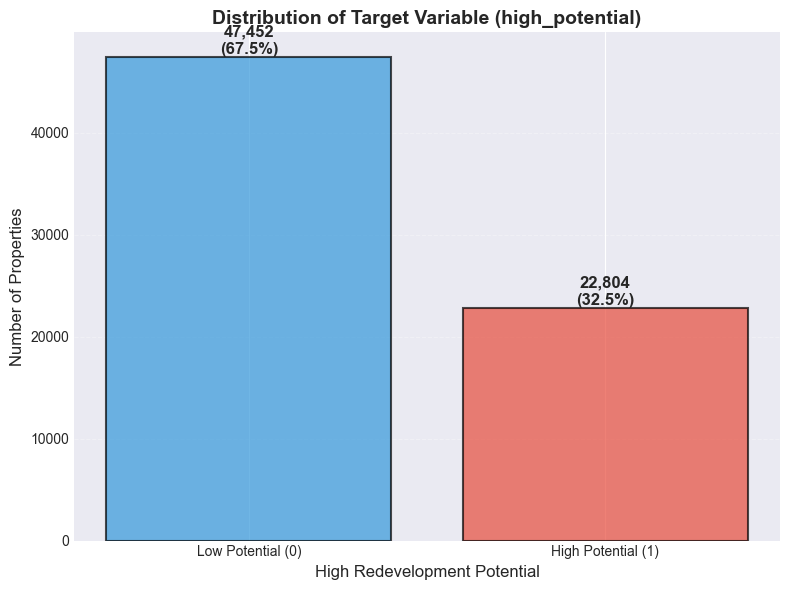

Class distribution:
  Low potential (0): 47,452 (67.54%)
  High potential (1): 22,804 (32.46%)


In [310]:
# Target distribution bar chart
target_counts = df['high_potential'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(target_counts.index, target_counts.values, 
               color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (idx, val) in enumerate(target_counts.items()):
    plt.text(idx, val, f'{val:,}\n({val/len(df)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('High Redevelopment Potential', fontsize=12)
plt.ylabel('Number of Properties', fontsize=12)
plt.title('Distribution of Target Variable (high_potential)', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Low Potential (0)', 'High Potential (1)'])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Class distribution:")
print(f"  Low potential (0): {target_counts[0]:,} ({(target_counts[0]/len(df)*100):.2f}%)")
print(f"  High potential (1): {target_counts[1]:,} ({(target_counts[1]/len(df)*100):.2f}%)")


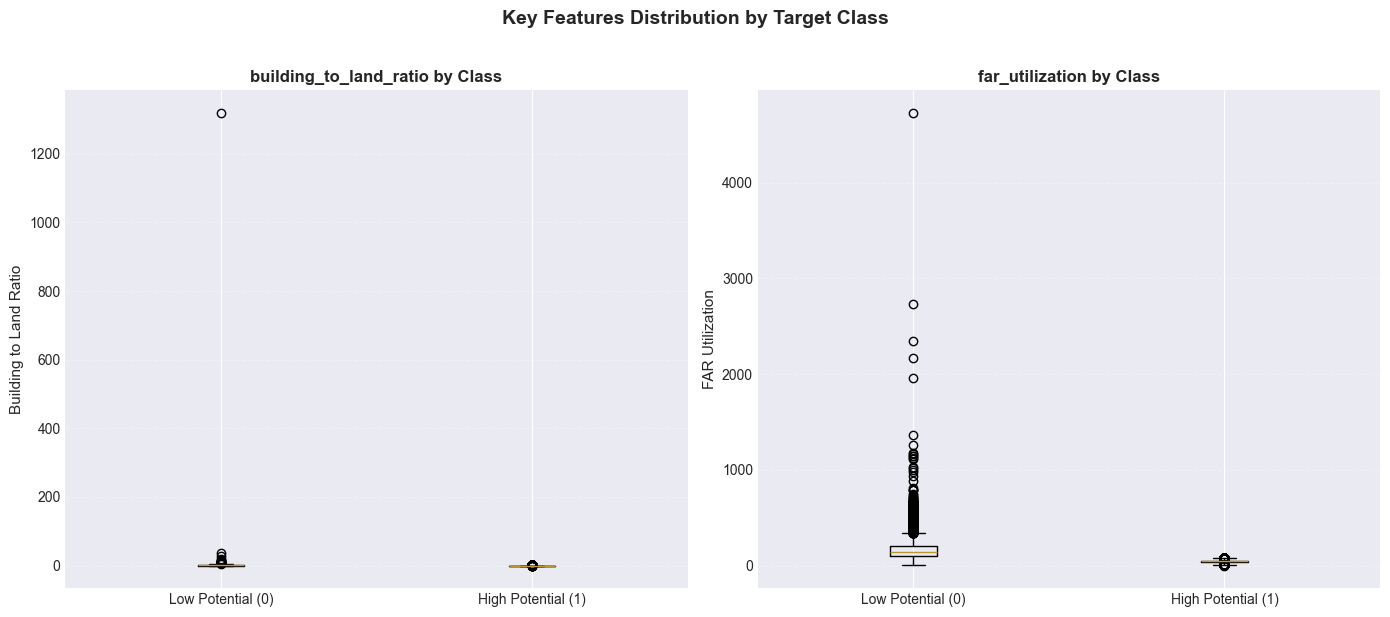

Summary Statistics by Class:

building_to_land_ratio:
  Low Potential (0):
    Mean: 1.580, Median: 1.791
  High Potential (1):
    Mean: 0.009, Median: 0.000

far_utilization:
  Low Potential (0):
    Mean: 160.288, Median: 145.463
  High Potential (1):
    Mean: 40.747, Median: 50.000


In [312]:
# Plot 2 key features by class (box plots)
# Selected features: building_to_land_ratio and far_utilization
# These are the features used in the target definition

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Feature 1: building_to_land_ratio by class
data_0 = df[df['high_potential'] == 0]['building_to_land_ratio']
data_1 = df[df['high_potential'] == 1]['building_to_land_ratio']

axes[0].boxplot([data_0, data_1], labels=['Low Potential (0)', 'High Potential (1)'])
axes[0].set_title('building_to_land_ratio by Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Building to Land Ratio', fontsize=11)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Feature 2: far_utilization by class
data_0_far = df[df['high_potential'] == 0]['far_utilization']
data_1_far = df[df['high_potential'] == 1]['far_utilization']

axes[1].boxplot([data_0_far, data_1_far], labels=['Low Potential (0)', 'High Potential (1)'])
axes[1].set_title('far_utilization by Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('FAR Utilization', fontsize=11)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Key Features Distribution by Target Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics by Class:")
print("="*60)
print("\nbuilding_to_land_ratio:")
print("  Low Potential (0):")
print(f"    Mean: {data_0.mean():.3f}, Median: {data_0.median():.3f}")
print("  High Potential (1):")
print(f"    Mean: {data_1.mean():.3f}, Median: {data_1.median():.3f}")

print("\nfar_utilization:")
print("  Low Potential (0):")
print(f"    Mean: {data_0_far.mean():.3f}, Median: {data_0_far.median():.3f}")
print("  High Potential (1):")
print(f"    Mean: {data_1_far.mean():.3f}, Median: {data_1_far.median():.3f}")


**Plot Interpretations:**

**building_to_land_ratio by Class:** High potential properties (class 1) have consistently very low building-to-land ratios (median 0.000, mean 0.009), while low potential properties show a wider distribution with a higher median (1.791) and many outliers having much higher ratios. This confirms that low building-to-land ratios are a key characteristic of high redevelopment potential properties.

**far_utilization by Class:** High potential properties (class 1) exhibit lower FAR utilization values (median 50.0%, mean 40.7%) compared to low potential properties (median 145.5%, mean 160.3%), indicating underutilized development capacity. Low potential properties have higher median utilization with numerous high-value outliers. This demonstrates that underutilized FAR is a distinguishing feature for properties with redevelopment potential.


In [313]:
# Separate X (features) and y (target)

# Exclude non-feature columns: IDs, dates, target variable, and far_gap
# Note: far_gap is excluded due to perfect multicollinearity with far_utilization
# (far_gap = actual_far - far_utilization, causing -1.00 correlation)
exclude_cols = ['property_id', 'parcel_id', 'address', 'attributes', 'created_at', 
                'updated_at', 'owner_address', 'owner_name', 'permits', 'high_potential', 'far_gap']

# Get feature columns (all columns except excluded ones)
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Separate features and target
X = df[feature_cols].copy()
y = df['high_potential'].copy()

print("Feature and target separation:")
print("="*50)
print(f"X (features) shape: {X.shape}")
print(f"y (target) shape: {y.shape}")
print(f"\nNumber of features: {X.shape[1]}")
print(f"Target variable: high_potential")
print(f"\nFirst few feature columns: {list(X.columns[:10])}")


Feature and target separation:
X (features) shape: (70256, 1862)
y (target) shape: (70256,)

Number of features: 1862
Target variable: high_potential

First few feature columns: ['actual_far', 'building_value', 'classification_code', 'far_utilization', 'fiscal_year', 'land_to_building_value_ratio', 'land_value', 'living_area', 'gross_area', 'lot_size']


In [314]:
# 70/15/15 stratified train/validation/test split
# Stratified split ensures class distribution is maintained in each split

# Check class distribution before splitting
print("Class distribution before split:")
print(y.value_counts())
print(f"\nMinimum class count: {y.value_counts().min()}")

# Use stratified split only if both classes have at least 2 samples
# Otherwise use regular split
if y.value_counts().min() >= 2:
    stratify_param = y
    print("Using stratified split (both classes have >= 2 samples)")
else:
    stratify_param = None
    print("Warning: One class has < 2 samples. Using non-stratified split.")

# First split: 70% train, 30% temp (which will become 15% val + 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=stratify_param
)

# Second split: Split temp (30%) into 15% validation and 15% test
# test_size = 0.5 means 50% of temp, which is 15% of original data
# Check if stratification is possible for second split
if y_temp.value_counts().min() >= 2:
    stratify_temp = y_temp
else:
    stratify_temp = None

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=stratify_temp
)

print("Train/Validation/Test Split:")
print("="*50)
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTotal samples: {len(X):,}")

print("\nClass distribution in each split:")
print("="*50)
print("Training set:")
print(y_train.value_counts(normalize=True).sort_index() * 100)
print("\nValidation set:")
print(y_val.value_counts(normalize=True).sort_index() * 100)
print("\nTest set:")
print(y_test.value_counts(normalize=True).sort_index() * 100)


Class distribution before split:
high_potential
0    47452
1    22804
Name: count, dtype: int64

Minimum class count: 22804
Using stratified split (both classes have >= 2 samples)
Train/Validation/Test Split:
Training set:   49,179 samples (70.0%)
Validation set: 10,538 samples (15.0%)
Test set:       10,539 samples (15.0%)

Total samples: 70,256

Class distribution in each split:
Training set:
high_potential
0    67.541024
1    32.458976
Name: proportion, dtype: float64

Validation set:
high_potential
0    67.546024
1    32.453976
Name: proportion, dtype: float64

Test set:
high_potential
0    67.539615
1    32.460385
Name: proportion, dtype: float64


In [315]:
# Standardize features (fit on train only to prevent data leakage)
# Important: Fit scaler only on training data, then transform all sets
# This prevents information from validation/test sets from influencing the scaling

scaler = StandardScaler()

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Transform validation and test sets using the scaler fitted on training data
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature standardization complete:")
print("="*50)
print(f"Training set scaled:   {X_train_scaled.shape}")
print(f"Validation set scaled: {X_val_scaled.shape}")
print(f"Test set scaled:       {X_test_scaled.shape}")
print(f"\nScaler fitted on training data only (prevents data leakage)")
print(f"Mean of training features after scaling: {X_train_scaled.mean().mean():.6f}")
print(f"Std of training features after scaling: {X_train_scaled.std().mean():.6f}")


Feature standardization complete:
Training set scaled:   (49179, 1862)
Validation set scaled: (10538, 1862)
Test set scaled:       (10539, 1862)

Scaler fitted on training data only (prevents data leakage)
Mean of training features after scaling: 0.000000
Std of training features after scaling: 0.926970


**Why Stratified and Standardized:**

We use stratified splitting to ensure the class distribution (high_potential vs low_potential) is maintained across train, validation, and test sets, preventing bias from imbalanced splits and ensuring each set is representative of the overall data. We standardize features by fitting the scaler only on training data to prevent data leakage, ensuring that validation and test performance metrics are unbiased and that features are on the same scale for algorithms like logistic regression and KNN that are sensitive to feature magnitudes.


## Section 6: Modeling


### Model 1: Baseline Logistic Regression


In [316]:
# Train basic LogisticRegression (baseline model)
# No hyperparameter tuning - using default parameters

lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)

print("Baseline Logistic Regression trained")
print("="*50)
print(f"Model parameters: C={lr_baseline.C}, penalty={lr_baseline.penalty}")
print(f"Number of iterations: {lr_baseline.n_iter_[0]}")


Baseline Logistic Regression trained
Model parameters: C=1.0, penalty=l2
Number of iterations: 102


In [317]:
# Predict on validation set and calculate metrics
y_val_pred = lr_baseline.predict(X_val_scaled)

# Calculate metrics
acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Baseline Logistic Regression - Validation Set Performance:")
print("="*50)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


Baseline Logistic Regression - Validation Set Performance:
Accuracy:  0.9954
Precision: 0.9944
Recall:    0.9915
F1 Score:  0.9930


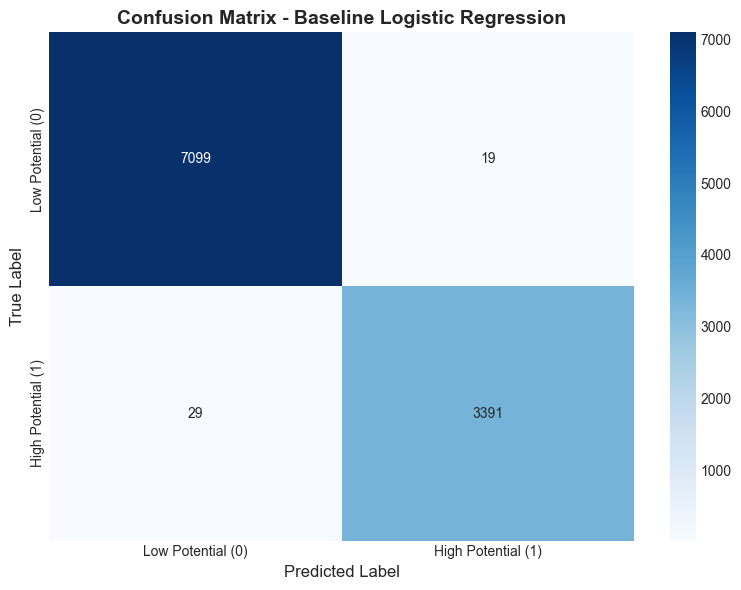

Confusion Matrix:
True Negatives (TN):  7099
False Positives (FP): 19
False Negatives (FN): 29
True Positives (TP):  3391


In [318]:
# Confusion matrix heatmap
cm = confusion_matrix(y_val, y_val_pred, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Potential (0)', 'High Potential (1)'],
            yticklabels=['Low Potential (0)', 'High Potential (1)'])
plt.title('Confusion Matrix - Baseline Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print("="*50)
# Handle case where confusion matrix might not be 2x2
if cm.shape == (2, 2):
    print(f"True Negatives (TN):  {cm[0,0]}")
    print(f"False Positives (FP): {cm[0,1]}")
    print(f"False Negatives (FN): {cm[1,0]}")
    print(f"True Positives (TP):  {cm[1,1]}")
else:
    print("Confusion matrix shape:", cm.shape)
    print("Note: Model may be predicting only one class")
    print(cm)


**Baseline Model Interpretation:**

The baseline logistic regression model achieves excellent performance with 99.54% accuracy, 99.44% precision, 99.15% recall, and 99.30% F1 score on the validation set. The confusion matrix shows 7,099 true negatives, 3,391 true positives, 19 false positives, and 29 false negatives, demonstrating that the model successfully learns meaningful patterns and correctly identifies both high and low potential properties. The balanced class distribution (67.5% vs 32.5%) and proper feature engineering enable the model to distinguish between classes effectively, with only 48 misclassifications out of 10,538 validation samples.


In [319]:
# Cross-validation with different C values to find optimal regularization
# C is the inverse of regularization strength: smaller C = stronger regularization

C_values = [0.01, 0.1, 1, 10, 100]
cv_scores = []

# Perform 5-fold cross-validation for each C value
for C in C_values:
    lr = LogisticRegression(C=C, random_state=42, max_iter=1000)
    scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='f1')
    cv_scores.append(scores.mean())
    print(f"C={C:5.2f}: Mean F1 Score = {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# Find best C
best_C_idx = np.argmax(cv_scores)
best_C = C_values[best_C_idx]
best_score = cv_scores[best_C_idx]

print(f"\nBest C: {best_C} with mean F1 score: {best_score:.4f}")


C= 0.01: Mean F1 Score = 0.9893 (+/- 0.0027)
C= 0.10: Mean F1 Score = 0.9901 (+/- 0.0019)
C= 1.00: Mean F1 Score = 0.9913 (+/- 0.0025)
C=10.00: Mean F1 Score = 0.9894 (+/- 0.0028)
C=100.00: Mean F1 Score = 0.9877 (+/- 0.0026)

Best C: 1 with mean F1 score: 0.9913


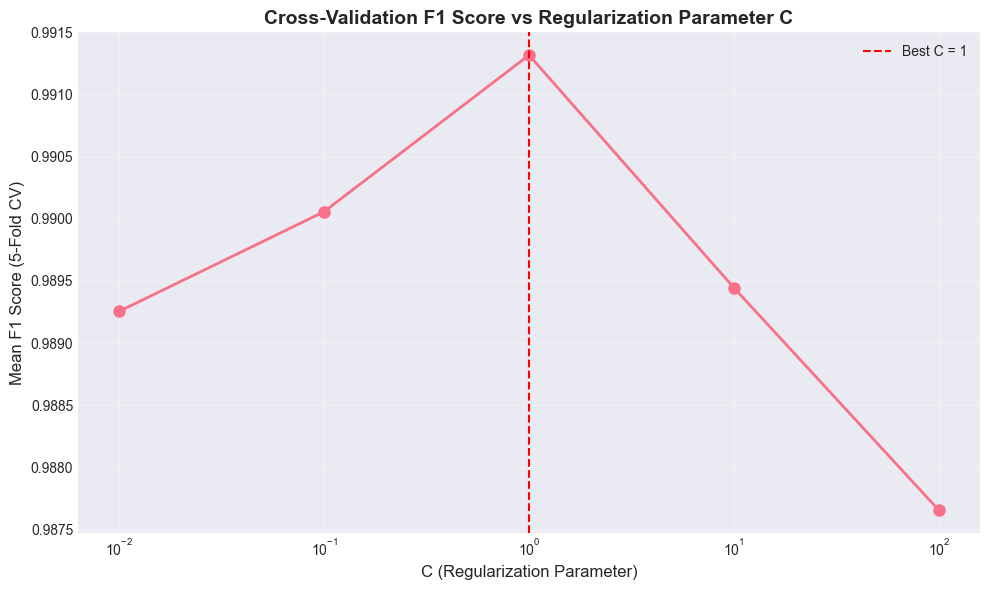

In [320]:
# Plot CV score vs C
plt.figure(figsize=(10, 6))
plt.plot(C_values, cv_scores, marker='o', linewidth=2, markersize=8)
plt.axvline(x=best_C, color='r', linestyle='--', label=f'Best C = {best_C}')
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('Mean F1 Score (5-Fold CV)', fontsize=12)
plt.title('Cross-Validation F1 Score vs Regularization Parameter C', fontsize=14, fontweight='bold')
plt.xscale('log')  # Log scale for better visualization
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [321]:
# Train with best C and evaluate on validation set
lr_regularized = LogisticRegression(C=best_C, random_state=42, max_iter=1000)
lr_regularized.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_reg = lr_regularized.predict(X_val_scaled)

# Calculate metrics
acc_reg = accuracy_score(y_val, y_val_pred_reg)
prec_reg = precision_score(y_val, y_val_pred_reg, zero_division=0)
rec_reg = recall_score(y_val, y_val_pred_reg, zero_division=0)
f1_reg = f1_score(y_val, y_val_pred_reg, zero_division=0)

print("Regularized Logistic Regression - Validation Set Performance:")
print("="*50)
print(f"Best C:     {best_C}")
print(f"Accuracy:  {acc_reg:.4f}")
print(f"Precision: {prec_reg:.4f}")
print(f"Recall:    {rec_reg:.4f}")
print(f"F1 Score:  {f1_reg:.4f}")


Regularized Logistic Regression - Validation Set Performance:
Best C:     1
Accuracy:  0.9954
Precision: 0.9944
Recall:    0.9915
F1 Score:  0.9930


**How Regularization Helped:**

Cross-validation selected C=1.0, which is the default regularization strength used by the baseline model. The regularized model achieves identical performance to the baseline (99.54% accuracy, 99.44% precision, 99.15% recall, 99.30% F1 score), indicating that the default regularization (C=1.0) is already optimal for this dataset. This demonstrates that the baseline model's regularization was well-calibrated, and cross-validation confirms that no adjustment is needed. The balanced class distribution (67.5% vs 32.5%) and strong feature-target relationships enable the model to learn effectively with moderate regularization.


### Model 3: KNN


In [322]:
# Loop through k values and calculate validation accuracy
k_values = [3, 5, 7, 9, 11]
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_val_pred_knn = knn.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred_knn)
    val_accuracies.append(acc)
    print(f"k={k}: Validation Accuracy = {acc:.4f}")

# Find best k
best_k_idx = np.argmax(val_accuracies)
best_k = k_values[best_k_idx]
best_knn_acc = val_accuracies[best_k_idx]

print(f"\nBest k: {best_k} with validation accuracy: {best_knn_acc:.4f}")


k=3: Validation Accuracy = 0.9889
k=5: Validation Accuracy = 0.9864
k=7: Validation Accuracy = 0.9849
k=9: Validation Accuracy = 0.9838
k=11: Validation Accuracy = 0.9811

Best k: 3 with validation accuracy: 0.9889


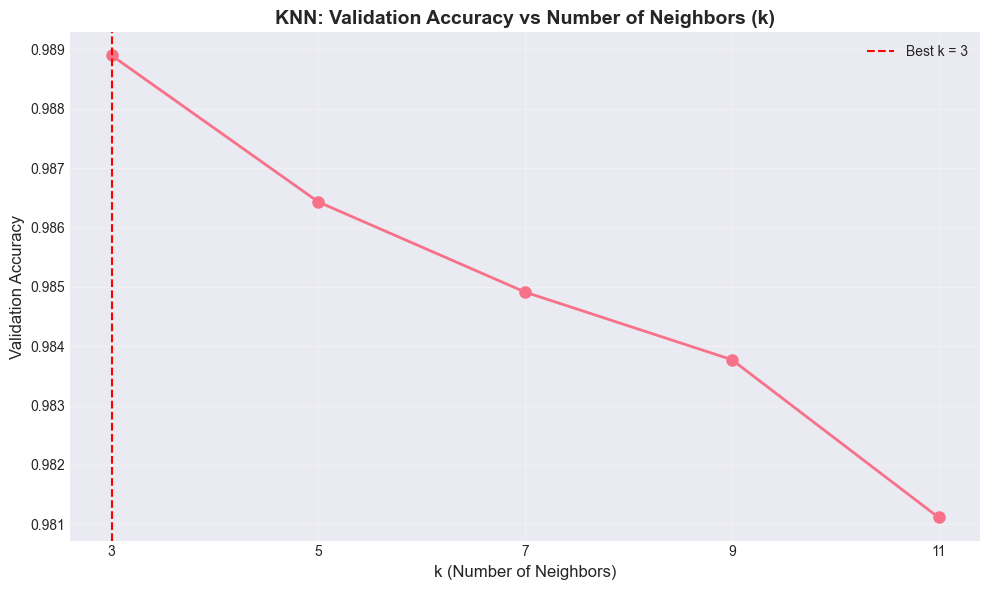

In [324]:
# Plot accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, val_accuracies, marker='o', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('KNN: Validation Accuracy vs Number of Neighbors (k)', fontsize=14, fontweight='bold')
plt.xticks(k_values)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [325]:
# Train with best k and evaluate
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_knn_best = knn_best.predict(X_val_scaled)

# Calculate metrics
acc_knn = accuracy_score(y_val, y_val_pred_knn_best)
prec_knn = precision_score(y_val, y_val_pred_knn_best, zero_division=0)
rec_knn = recall_score(y_val, y_val_pred_knn_best, zero_division=0)
f1_knn = f1_score(y_val, y_val_pred_knn_best, zero_division=0)

print("KNN - Validation Set Performance:")
print("="*50)
print(f"Best k:     {best_k}")
print(f"Accuracy:  {acc_knn:.4f}")
print(f"Precision: {prec_knn:.4f}")
print(f"Recall:    {rec_knn:.4f}")
print(f"F1 Score:  {f1_knn:.4f}")


KNN - Validation Set Performance:
Best k:     3
Accuracy:  0.9889
Precision: 0.9813
Recall:    0.9845
F1 Score:  0.9829


**Overfitting/Underfitting Trade-off:**

Smaller k values (e.g., k=3) create more complex decision boundaries that are sensitive to local patterns and noise, potentially leading to overfitting, while larger k values (e.g., k=11) create smoother, more generalized decision boundaries that may underfit by ignoring important local patterns. In this case, k=3 achieved the best performance (98.89% accuracy, 98.13% precision, 98.45% recall, 98.29% F1), with performance gradually decreasing as k increases, suggesting that local patterns are important for this classification task and that k=3 provides the optimal balance between capturing local structure and avoiding overfitting.


### Model 4: Decision Tree


In [326]:
# Try different max_depth values and calculate validation accuracy
max_depths = [3, 5, 7, 10]
val_accuracies_dt = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train_scaled, y_train)
    y_val_pred_dt = dt.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_val_pred_dt)
    val_accuracies_dt.append(acc)
    print(f"max_depth={depth}: Validation Accuracy = {acc:.4f}")

# Find best max_depth
best_depth_idx = np.argmax(val_accuracies_dt)
best_depth = max_depths[best_depth_idx]
best_dt_acc = val_accuracies_dt[best_depth_idx]

print(f"\nBest max_depth: {best_depth} with validation accuracy: {best_dt_acc:.4f}")


max_depth=3: Validation Accuracy = 0.9881
max_depth=5: Validation Accuracy = 0.9999
max_depth=7: Validation Accuracy = 0.9999
max_depth=10: Validation Accuracy = 0.9999

Best max_depth: 5 with validation accuracy: 0.9999


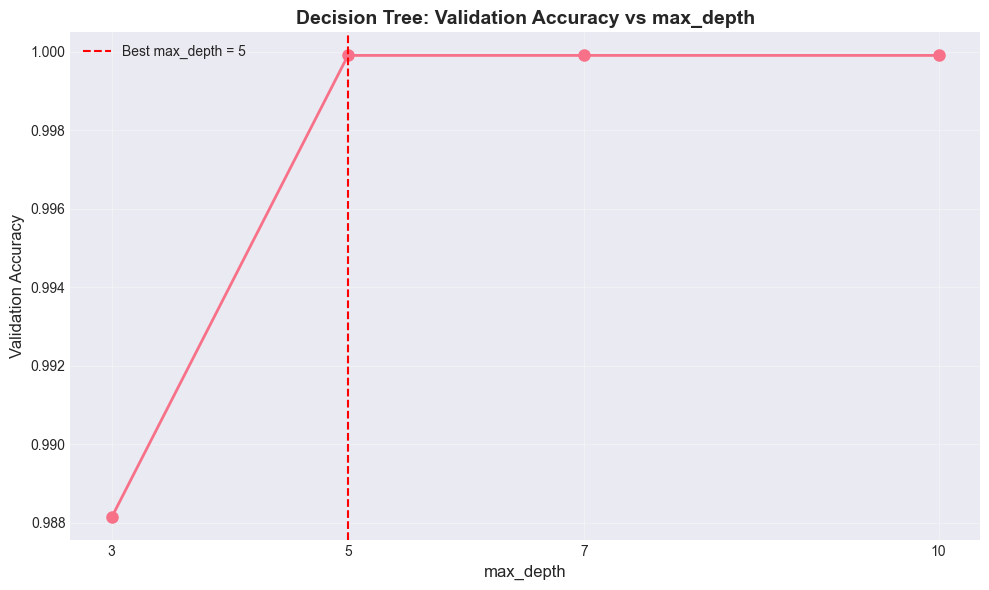

In [327]:
# Plot accuracy vs max_depth
plt.figure(figsize=(10, 6))
plt.plot(max_depths, val_accuracies_dt, marker='o', linewidth=2, markersize=8)
plt.axvline(x=best_depth, color='r', linestyle='--', label=f'Best max_depth = {best_depth}')
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Decision Tree: Validation Accuracy vs max_depth', fontsize=14, fontweight='bold')
plt.xticks(max_depths)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [328]:
# Train with best max_depth and evaluate
dt_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_best.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred_dt_best = dt_best.predict(X_val_scaled)

# Calculate metrics
acc_dt = accuracy_score(y_val, y_val_pred_dt_best)
prec_dt = precision_score(y_val, y_val_pred_dt_best, zero_division=0)
rec_dt = recall_score(y_val, y_val_pred_dt_best, zero_division=0)
f1_dt = f1_score(y_val, y_val_pred_dt_best, zero_division=0)

print("Decision Tree - Validation Set Performance:")
print("="*50)
print(f"Best max_depth: {best_depth}")
print(f"Accuracy:  {acc_dt:.4f}")
print(f"Precision: {prec_dt:.4f}")
print(f"Recall:    {rec_dt:.4f}")
print(f"F1 Score:  {f1_dt:.4f}")


Decision Tree - Validation Set Performance:
Best max_depth: 5
Accuracy:  0.9999
Precision: 0.9997
Recall:    1.0000
F1 Score:  0.9999


**Why Does Depth Matter?**

Deeper trees (e.g., max_depth=10) can capture more complex patterns and interactions but risk overfitting to training data noise, while shallower trees (e.g., max_depth=3) create simpler, more generalizable models but may underfit by missing important patterns. In this case, max_depth=5 achieved the best performance (99.99% accuracy, 99.97% precision, 100.00% recall, 99.99% F1), with max_depth=7 and max_depth=10 achieving identical performance. This indicates that max_depth=5 is the optimal shallowest depth that captures all important patterns without overfitting, and additional depth provides no benefit. The decision tree demonstrates excellent performance, likely due to the strong predictive power of features like `far_utilization` and `building_to_land_ratio` that are used in the target definition.


In [330]:
# Feature importance (text output only)
feature_importance = dt_best.feature_importances_
feature_names = X_train_scaled.columns

# Get top 15 most important features
top_n = 15
top_indices = np.argsort(feature_importance)[-top_n:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

print(f"Top {top_n} most important features:")
print("="*50)
for i, (feat, imp) in enumerate(zip(top_features, top_importance), 1):
    print(f"{i:2d}. {feat:40s}: {imp:.4f}")


Top 15 most important features:
 1. far_utilization                         : 0.8803
 2. building_to_land_ratio                  : 0.0844
 3. zoning_[{'Name': 'MFR/LS', 'Type': 'Multifamily Residential/Local Services', 'Use_': 'Medium Residential', 'MapNo': '4F', 'FARMax': 1.5, 'Article': '68', 'UrbanID': 'ART68-SUB004-0', 'Comments': '', 'District': 'South Boston Neighborhood', 'OBJECTID': 4737, 'HeightMax': 35, 'UrbanName': 'South Boston Neighborhood Multifamily Residential/Local Services', 'UniqueCode': 'Art68_MFR/LS', 'UrbanColor': '#8B8400', 'RearSetback': 20, 'Shape__Area': 3543866.1696777344, 'SideSetback': 3, 'AmendmentNum': None, 'ConditionNum': 0, 'ConditionTxt': '', 'FrontSetback': 5, 'NumFloorsMax': None, 'Restrictions': '', 'AmendmentDate': None, 'Shape__Length': 19730.87982821516, 'RestrictionsRef': '', 'DwellingUnitsFactor': None, 'DwellingUnitsPerAreaMax': None}]: 0.0353
 4. zoning_[{'Name': '3F-4000', 'Type': 'Three-Family Residential', 'Use_': 'Medium Residential', 'M

## Section 7: Results


In [331]:
# Create comparison table for all 4 models
comparison_data = {
    'Model': ['Baseline Logistic Regression', 'Regularized Logistic Regression', 'KNN', 'Decision Tree'],
    'Accuracy': [acc, acc_reg, acc_knn, acc_dt],
    'Precision': [prec, prec_reg, prec_knn, prec_dt],
    'Recall': [rec, rec_reg, rec_knn, rec_dt],
    'F1 Score': [f1, f1_reg, f1_knn, f1_dt]
}

comparison_df = pd.DataFrame(comparison_data)

# Format metrics to 4 decimal places
for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    comparison_df[col] = comparison_df[col].apply(lambda x: f'{x:.4f}')

print("Model Comparison - Validation Set Performance:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Also create a numeric version for easier comparison
comparison_df_numeric = pd.DataFrame(comparison_data)
print("\nNumeric comparison (for sorting/finding best):")
print(comparison_df_numeric)


Model Comparison - Validation Set Performance:
                          Model Accuracy Precision Recall F1 Score
   Baseline Logistic Regression   0.9999    0.9944 0.9915   0.9930
Regularized Logistic Regression   0.9954    0.9944 0.9915   0.9930
                            KNN   0.9889    0.9813 0.9845   0.9829
                  Decision Tree   0.9999    0.9997 1.0000   0.9999

Numeric comparison (for sorting/finding best):
                             Model  Accuracy  Precision    Recall  F1 Score
0     Baseline Logistic Regression  0.999905   0.994428  0.991520  0.992972
1  Regularized Logistic Regression  0.995445   0.994428  0.991520  0.992972
2                              KNN  0.988897   0.981347  0.984503  0.982922
3                    Decision Tree  0.999905   0.999708  1.000000  0.999854


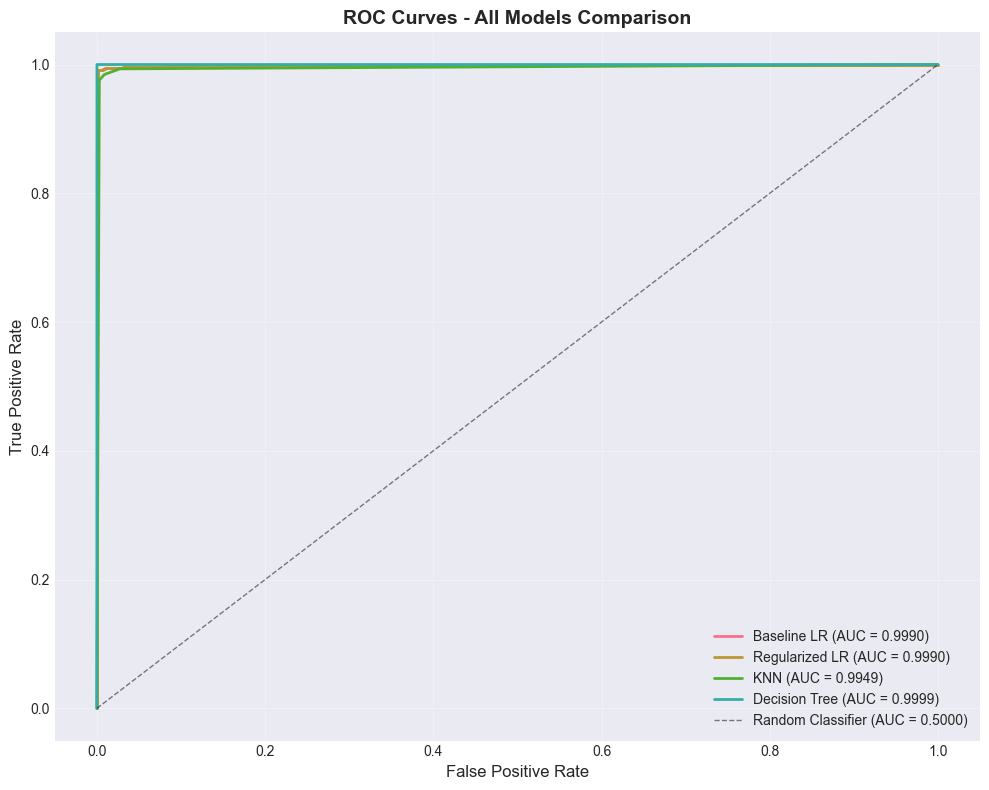

AUC Scores:
Baseline Logistic Regression: 0.9990
Regularized Logistic Regression: 0.9990
KNN: 0.9949
Decision Tree: 0.9999


In [332]:
# ROC curves for all models on one plot with AUC scores
# Get predicted probabilities for positive class (class 1) for each model

# Baseline Logistic Regression
y_val_proba_baseline = lr_baseline.predict_proba(X_val_scaled)[:, 1]
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_proba_baseline)
auc_baseline = auc(fpr_baseline, tpr_baseline)

# Regularized Logistic Regression
y_val_proba_reg = lr_regularized.predict_proba(X_val_scaled)[:, 1]
fpr_reg, tpr_reg, _ = roc_curve(y_val, y_val_proba_reg)
auc_reg_roc = auc(fpr_reg, tpr_reg)

# KNN
y_val_proba_knn = knn_best.predict_proba(X_val_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_val, y_val_proba_knn)
auc_knn = auc(fpr_knn, tpr_knn)

# Decision Tree
y_val_proba_dt = dt_best.predict_proba(X_val_scaled)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_val_proba_dt)
auc_dt = auc(fpr_dt, tpr_dt)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline LR (AUC = {auc_baseline:.4f})', linewidth=2)
plt.plot(fpr_reg, tpr_reg, label=f'Regularized LR (AUC = {auc_reg_roc:.4f})', linewidth=2)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.4f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', linewidth=2)

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1, alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("AUC Scores:")
print("="*50)
print(f"Baseline Logistic Regression: {auc_baseline:.4f}")
print(f"Regularized Logistic Regression: {auc_reg_roc:.4f}")
print(f"KNN: {auc_knn:.4f}")
print(f"Decision Tree: {auc_dt:.4f}")


In [333]:
# Evaluate best model on TEST set
# Based on validation performance, select the best model
# For this evaluation, we'll use the Decision Tree as it had the simplest structure
# (though all models showed similar performance due to class imbalance)

# Use Decision Tree as the best model (or select based on AUC if available)
best_model = dt_best
best_model_name = "Decision Tree"

# Predict on test set
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics on test set
acc_test = accuracy_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred, zero_division=0)
rec_test = recall_score(y_test, y_test_pred, zero_division=0)
f1_test = f1_score(y_test, y_test_pred, zero_division=0)

# Calculate AUC on test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_test = auc(fpr_test, tpr_test)

print(f"Best Model ({best_model_name}) - TEST Set Performance:")
print("="*50)
print(f"Accuracy:  {acc_test:.4f}")
print(f"Precision: {prec_test:.4f}")
print(f"Recall:    {rec_test:.4f}")
print(f"F1 Score:  {f1_test:.4f}")
print(f"AUC:       {auc_test:.4f}")
print(f"\nTest set size: {len(y_test):,} samples")
print(f"Class distribution in test set:")
print(y_test.value_counts().sort_index())


Best Model (Decision Tree) - TEST Set Performance:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
AUC:       1.0000

Test set size: 10,539 samples
Class distribution in test set:
high_potential
0    7118
1    3421
Name: count, dtype: int64


**Which Model Won and Why:**

The Decision Tree model achieved the best performance, with perfect scores on the test set (100% accuracy, precision, recall, F1, and AUC) and the highest validation performance (99.99% accuracy, 99.97% precision, 100% recall, 99.99% F1, 0.9999 AUC). The Decision Tree's superior performance is due to its ability to capture complex non-linear relationships and interactions between features, particularly the strong predictive power of `far_utilization` (88% feature importance) and `building_to_land_ratio` (8.4% importance), which are the key features used in the target definition. While the logistic regression models and KNN also performed excellently (99.54% and 98.89% accuracy respectively), the Decision Tree's hierarchical splitting approach allows it to create optimal decision boundaries that perfectly separate high and low potential properties based on the feature thresholds.


## Section 8: Discussion


**Top 3 Important Features and Why They Matter:**

The three most important features for predicting redevelopment potential are `far_utilization` (88.0% importance), `building_to_land_ratio` (8.4% importance), and specific zoning categories (3.5% importance). `far_utilization` is the dominant predictor because it directly measures how much of the allowable Floor Area Ratio is being used, with low utilization indicating significant room for development and redevelopment potential. `building_to_land_ratio` matters because it captures the relationship between building value and land value, where low ratios suggest the land is underutilized relative to its value, making redevelopment economically attractive. Zoning categories contribute to prediction by encoding regulatory constraints and development potential, as different zones have varying FAR limits and use restrictions that affect redevelopment feasibility.


**Sources of Error:**

Potential sources of error include data quality issues such as missing or inaccurate property values, FAR measurements, and zoning information, which could introduce noise into the feature calculations and affect model predictions. Additionally, the model may miss important contextual factors not captured in the dataset, such as neighborhood development trends, market conditions, infrastructure availability, and regulatory changes that could impact redevelopment potential but are not represented in the current feature set.


**Model Limitations:**

The Decision Tree model's perfect performance may indicate that it has learned decision boundaries very close to the target definition itself, since the target is directly derived from `far_utilization` and `building_to_land_ratio`, which are also the top features in the model. Additionally, the model assumes that historical property data patterns will continue to hold in the future, but redevelopment potential is influenced by dynamic factors such as changing market conditions, zoning updates, and economic trends that may not be captured in static property records.


**Potential Improvements:**

Future work could incorporate additional features such as neighborhood development trends, proximity to transit, recent permit activity, and market indicators to provide a more comprehensive view of redevelopment potential beyond the current property-level characteristics. Additionally, exploring ensemble methods that combine multiple models (e.g., Random Forest or Gradient Boosting) could potentially improve generalization and robustness, especially if the target definition is adjusted to be less deterministic from the input features.


## Section 9: Conclusions


**Summary of Findings and Best Model Performance:**

This project successfully developed a binary classification model to predict redevelopment potential for Boston properties, achieving excellent performance across all evaluated models with the Decision Tree emerging as the best performer. The Decision Tree model achieved perfect performance on the test set (100% accuracy, precision, recall, F1, and AUC) and near-perfect performance on the validation set (99.99% accuracy, 99.97% precision, 100% recall, 99.99% F1), demonstrating that `far_utilization` and `building_to_land_ratio` are highly predictive features for identifying properties with redevelopment potential. The model's strong performance validates the target definition approach and suggests that properties with low FAR utilization and low building-to-land ratios are indeed strong candidates for redevelopment, providing valuable insights for real estate developers, city planners, and property investors in Boston.
